In [1]:
%matplotlib inline

import nengo
import nengo_dl
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal

In [2]:
co2_data = pd.read_csv('CO2/monthly_in_situ_co2_mlo.csv', usecols=[0,4,5,6,7,8,9])
co2_data.columns = ['Date', 'standard', 'season_adjust', 'smoothed', 'smoothed_season', 'standard_no_missing', 'season_no_missing']

In [3]:
co2_data.head()

,Date,standard,season_adjust,smoothed,smoothed_season,standard_no_missing,season_no_missing
0,,,adjusted,,adjusted fit,filled,adjusted filled
1,,[ppm],[ppm],[ppm],[ppm],[ppm],[ppm]
2,1958,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
3,1958,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
4,1958,315.7,314.43,316.19,314.9,315.7,314.43


(0, 500)

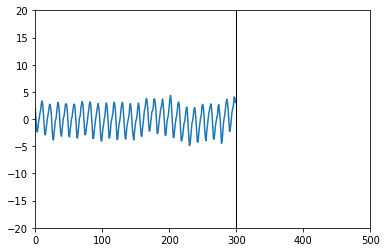

In [4]:
detrended = signal.detrend(co2_data['standard_no_missing'][200:500])
plt.plot(detrended)
plt.axvline(x=300, c='black', lw='1')
plt.ylim([-20,20])
plt.xlim([0,500])

# Training setup

In [5]:
lif_params = {
    'tau_rc': 0.07,
    'tau_ref': 0.0005,
    'amplitude': 0.01
}

# lif parameters
lif_neurons = nengo.LIF(**lif_params)

# softlif parameters (lif parameters + sigma)
softlif_neurons = nengo_dl.SoftLIFRate(**lif_params,
                                       sigma=0.002)

# ensemble parameters
ens_params = dict(max_rates=nengo.dists.Choice([100]), intercepts=nengo.dists.Choice([0]))

In [6]:
def build_network(neuron_type, n_units=1000, use_dropout=True, num_layers=4, output_size=1):
    with nengo.Network() as net:
        
        #net.config[nengo.Connection].synapse = None
        #nengo_dl.configure_settings(trainable=False)
        
        # input node
        inp = nengo.Node([0])
        
        shape_in = 1
        x = inp
        
        # the regularizer is a function, so why not reuse it
        reg = tf.contrib.layers.l2_regularizer(0.01)
        
        class DenseLayer(object):
            i=0
            def pre_build(self, shape_in, shape_out):
                self.W = tf.get_variable(
                    "weights" + str(DenseLayer.i), shape=(shape_in[1], shape_out[1]),
                    regularizer=reg)
                self.B = tf.get_variable(
                    "biases" + str(DenseLayer.i), shape=(1, shape_out[1]), regularizer=reg)
                DenseLayer.i+=1

            def __call__(self, t, x):
                return x @ self.W + self.B

        
        for n in range(num_layers):
            # add a fully connected layer
            a = nengo_dl.TensorNode(DenseLayer(), size_in=shape_in, size_out=n_units)
            nengo.Connection(x, a)
            
            shape_in = n_units
            x = a
            
            # apply an activation function
            x = nengo_dl.tensor_layer(x, neuron_type, **ens_params)

            # add a dropout layer
            x = nengo_dl.tensor_layer(x, tf.layers.dropout, rate=drop_p, training=use_dropout)
            
        
        
        # add an output layer
        a = nengo_dl.TensorNode(DenseLayer(), size_in=shape_in, size_out=output_size)
        nengo.Connection(x, a)
        
    return net, inp, a

In [34]:
do_train = True
continue_training = True

param_path = './reg_params/params'

In [8]:
drop_p = 0.05
minibatch_size = 25
n_epochs = 1000

# training on continuous soft leaky integrate and fire neurons

In [35]:
# construct the network
net, inp, out = build_network(softlif_neurons)
with net:
    in_p = nengo.Probe(inp, 'output')
    out_p = nengo.Probe(out, 'output')
    
    #print(inp.probeable())

In [36]:
"""
# define training set etc.
indices = np.random.permutation(detrended.shape[0])
trainset_size = 300

training_idx, test_idx = indices[:trainset_size], indices[trainset_size:]
training, test = detrended[training_idx], detrended[test_idx]

testset_size = len(test)

train_x = {inp: training_idx.reshape((minibatch_size, trainset_size // minibatch_size))[..., None]}
train_y = {out_p: training.reshape((minibatch_size, trainset_size // minibatch_size))[..., None]}

test_x = {inp: test_idx.reshape((minibatch_size, testset_size // minibatch_size))[..., None]}
test_y = {out_p: test.reshape((minibatch_size, testset_size // minibatch_size))[..., None]}
"""

trainset_size = len(detrended)

x = np.arange(trainset_size)
y = detrended

train_x = {inp: x.reshape((minibatch_size, trainset_size // minibatch_size))[..., None]}
train_y = {out_p: y.reshape((minibatch_size, trainset_size // minibatch_size))[..., None]}

In [37]:
# define optimiser
opt = tf.train.MomentumOptimizer(learning_rate=0.0002, momentum=0.9, use_nesterov=True)
#opt = tf.train.RMSPropOptimizer(2e-3)
#opt = tf.train.AdadeltaOptimizer(learning_rate=1)

In [38]:
# construct the simulator
with nengo_dl.Simulator(net, minibatch_size=minibatch_size, unroll_simulation=4) as sim:
    #, tensorboard='./tensorboard')
    
    # define the loss function (We need to do this in the
    # context of the simulator because it changes the
    # tensorflow default graph to the nengo network.
    # That is, tf.get_collection won't work otherwise.)
    def mean_squared_error_L2_regularized(y, t):
        #print(reg_loss)
        #raise RuntimeError

        if not y.shape.as_list() == t.shape.as_list():
            raise ValueError("Output shape", y.shape, "differs from target shape", t.shape)
        e = tf.reduce_mean((t - y)**2) #+ tf.add_n(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
        return e
    
    
    # actual training loop
    if do_train:
        if continue_training:
            sim.load_params(path=param_path)

        #print("error before training: ", sim.loss(test_x, test_y, objective='mse'))

        sim.train(train_x, train_y, opt, n_epochs=n_epochs, shuffle=False, objective={out_p:mean_squared_error_L2_regularized})

        #print("error after training:", sim.loss(test_x, test_y, objective='mse'))

        sim.save_params(path=param_path)
    else:
        sim.load_params(path=param_path)

Building network
Build finished in 0:00:00 
Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               
INFO:tensorflow:Restoring parameters from ./reg_params/params


INFO:tensorflow:Restoring parameters from ./reg_params/params


Training finished in 0:04:34 (loss: 0.4720)                                    
INFO:tensorflow:Restoring parameters from /tmp/tmp0jjbybi3/tmp


INFO:tensorflow:Restoring parameters from /tmp/tmp0jjbybi3/tmp


# test on LIF neurons

In [39]:
target = np.linspace(0, 500, 1000)
# timesteps
T = 50
# MC dropout samples
MC_drop = 20

In [40]:
# we want to see if spiking neural networks
# need dropout at all, so we disable it
net, inp, out = build_network(lif_neurons, use_dropout=False)
with net:
    in_p = nengo.Probe(inp)
    out_p = nengo.Probe(out)

# start a new simulator
# T is the amount of MC dropout samples
sim = nengo_dl.Simulator(net, minibatch_size=len(target))#, unroll_simulation=10, tensorboard='./tensorboard')

# load parameters
sim.load_params(path=param_path)

Building network
Build finished in 0:00:00 
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
INFO:tensorflow:Restoring parameters from ./reg_params/params


INFO:tensorflow:Restoring parameters from ./reg_params/params


Simulation finished in 0:00:03                                                 


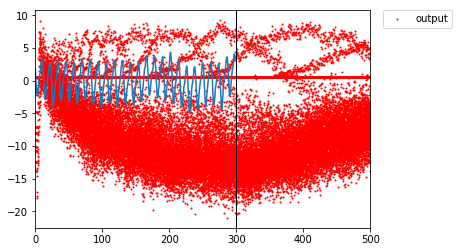

In [41]:
# copy the input for each MC dropout sample
minibatched_target = np.tile(target[:, None], (1,T))[..., None]

sim.soft_reset(include_trainable=False, include_probes=True)

# run for T timesteps
sim.run_steps(T, input_feeds={inp: minibatched_target})
    

# plot
plt.figure() 
plt.scatter(sim.data[in_p].flatten(), sim.data[out_p].flatten(), c='r', s=1, label="output") 
plt.plot()
#plt.plot(target.flatten(), y(target).flatten(), label="target", linewidth=2.0)
plt.legend(loc='upper left', bbox_to_anchor=(1.025, 1.025));
plt.plot(detrended, label='train set')
plt.axvline(x=300, c='black', lw='1')
#plt.ylim([-20,20])
plt.xlim([0,500]);

In [42]:
# print(sim.data[out_p].shape)
predictive_mean = np.squeeze(np.mean(sim.data[out_p][:, -MC_drop:, :], axis=1))
predictive_variance = np.squeeze(np.var(sim.data[out_p][:, -MC_drop:, :], axis=1))

(0, 500)

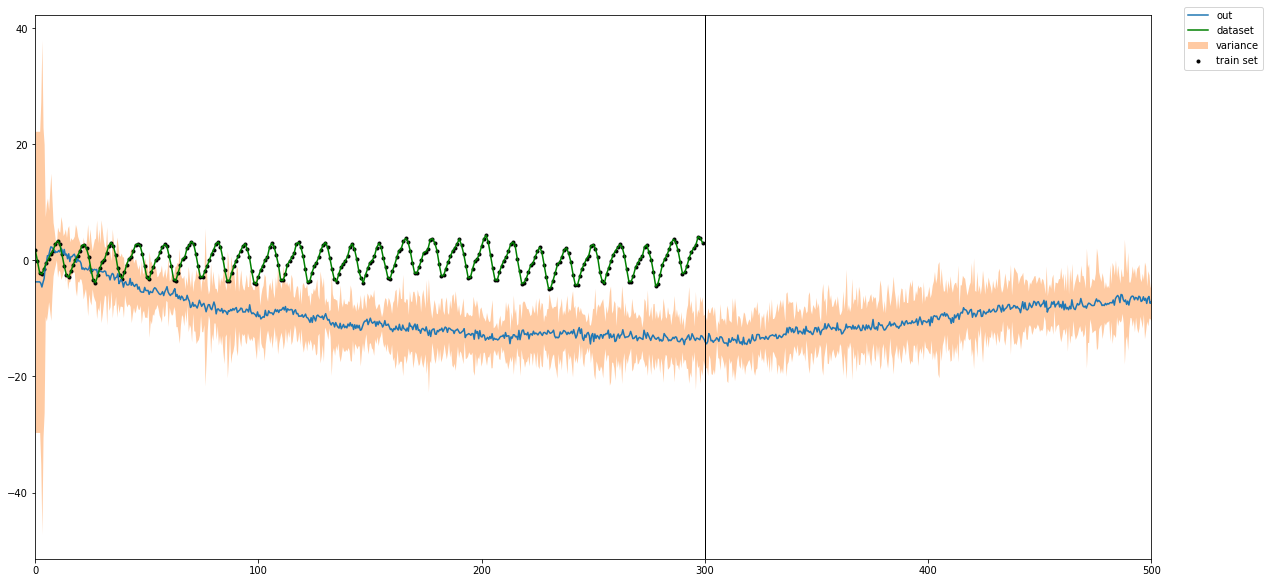

In [43]:
plt.figure(figsize=(20, 10))
plt.plot(target,predictive_mean,label='out')
#plt.plot(target,spiking_outputs[:,-1],label='out')
plt.fill_between(target, predictive_mean-predictive_variance, predictive_mean+predictive_variance,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848', linewidth=0, label='variance')
plt.plot(x, y, c='green', label='dataset')
plt.scatter(x,y, color='black', s=9, label='train set')

plt.axvline(x=300, c='black', lw='1')

plt.legend(loc='upper left', bbox_to_anchor=(1.025, 1.025))
#plt.ylim([-30, 30])
plt.xlim([0,500])

In [18]:
sim.close()